In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas Options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)

#Set Seaborn Theme
sns.set_style('darkgrid')

In [2]:
#Function to plot confusion matrix.

import itertools
from sklearn.metrics import confusion_matrix
from pdpbox import pdp, get_dataset, info_plots

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fig = plt.figure(1, figsize=(10, 6), dpi=600)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

# Data Collection For Block Groups

In [3]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
    , CASE WHEN fcc_fast.block_code IS NULL THEN 0 ELSE 1 END AS int_avail_fast
  FROM broadband.census_block block
  LEFT JOIN (SELECT block_code FROM broadband.fcc WHERE file_date = 201706 AND max_down >= 4.0
                                                                           AND max_up >= 1.0) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN (SELECT block_code FROM broadband.fcc WHERE file_date = 201706 AND max_down >= 25.0
                                                                           AND max_up >= 3.0) fcc_fast
    ON block.block_code = fcc_fast.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE 
      fcc_demography.population_2016 > 0 
      AND fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS broad_avail_per
    , AVG(int_avail_fast) AS broad_avail_per_fast
  FROM block_level
  GROUP BY block_group
),
fund AS (
    SELECT DISTINCT SUBSTR(census_block, 0, 12) AS block_group
    FROM broadband.fund
)

SELECT DISTINCT
  block_group_level.block_group
  , block_group_level.broad_avail_per
  , block_group_level.broad_avail_per_fast
  , SAFE_DIVIDE(tiger_acs.road_length, tiger_acs.land_area) AS road_density
  , tiger_acs.elev_mean
  , tiger_acs.elev_range
  , tiger_acs.winter_temp AS winter_temperature
  , SAFE_DIVIDE(tiger_acs.population, tiger_acs.land_area) AS population_density
  , tiger_acs.male_rate
  , tiger_acs.median_income
  , tiger_acs.median_age
  , tiger_acs.white_rate
  , tiger_acs.avg_years_of_edu
  , tiger_acs.unemployment_rate
  , SAFE_DIVIDE(tiger_acs.housing_units, tiger_acs.land_area) AS housing_density
  , tiger_acs.house_owner_rate
  , tiger_acs.newly_moved_household_rate
  , tiger_acs.newly_built_housing_rate
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN fund
  ON block_group_level.block_group = fund.block_group
LEFT JOIN broadband.tiger_acs_2016 AS tiger_acs
  ON block_group_level.block_group = tiger_acs.block_group
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
WHERE fund.block_group IS NULL
"""

all_data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')
all_data.columns = ['block_group', 'broad_avail_per', 'broad_avail_per_fast', 'Road Length Per Area',
                    'Elevation Mean', 'Elevation Range', 'Average Winter Temperature', 'Population Density',
                    'Male %', 'Median Income', 'Median Age', 'White %', 'Average Years of Education',
                    'Unemployment Rate', 'Housing Density', '% Owner Occupied Units', '% Newly Moved Households',
                    '% Newly Built Housing Units', 'Prohibition of Municipal Broadband']

In [4]:
all_data.shape

(190223, 19)

### Data Cleaning

Data completeness

In [5]:
all_data.count() / all_data.shape[0] * 100

block_group                           100.000000
broad_avail_per                       100.000000
broad_avail_per_fast                  100.000000
Road Length Per Area                   99.969509
Elevation Mean                         99.971612
Elevation Range                        99.971612
Average Winter Temperature             99.941647
Population Density                     99.969509
Male %                                 99.800234
Median Income                          97.165432
Median Age                             99.767115
White %                                99.800234
Average Years of Education             99.800234
Unemployment Rate                      99.714020
Housing Density                        99.969509
% Owner Occupied Units                 99.658296
% Newly Moved Households               99.658296
% Newly Built Housing Units            99.678272
Prohibition of Municipal Broadband    100.000000
dtype: float64

In [6]:
data = all_data.dropna()

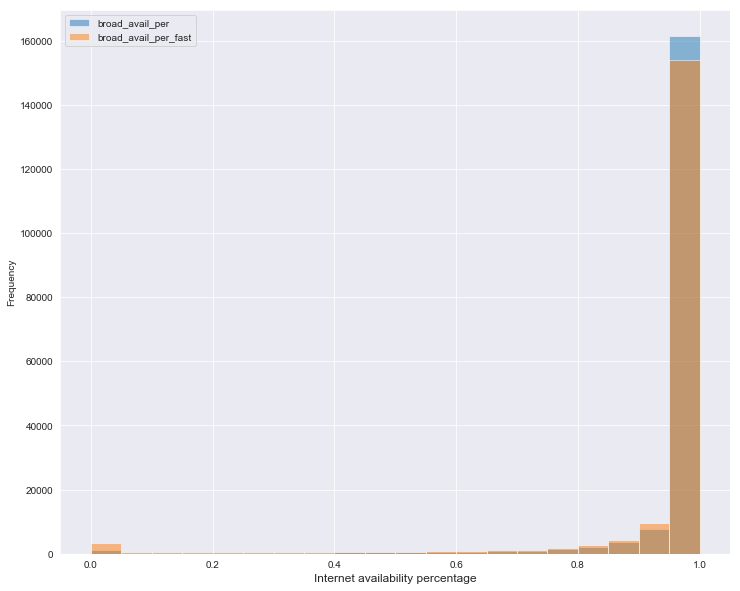

In [7]:
data[['broad_avail_per', 'broad_avail_per_fast']].plot.hist(bins=20, alpha=0.5, figsize=(12, 10))
plt.xlabel('Internet availability percentage', fontsize=12)
plt.show()

In [8]:
data[['broad_avail_per', 'broad_avail_per_fast']].describe()

,broad_avail_per,broad_avail_per_fast
count,184766.000000,184766.000000
mean,0.962170,0.941395
std,0.133898,0.179876
min,0.000000,0.000000
25%,0.996169,0.981982
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [9]:
full_coverage = (data.broad_avail_per == 1).sum() / data.shape[0] * 100
full_coverage_fast = (data.broad_avail_per_fast == 1).sum() / data.shape[0] * 100

print('block_group with full coverage', full_coverage)
print('block_group with full fast coverage', full_coverage_fast)

block_group with full coverage 74.63386120823095
block_group with full fast coverage 67.98815799443621


# Correlation Analysis

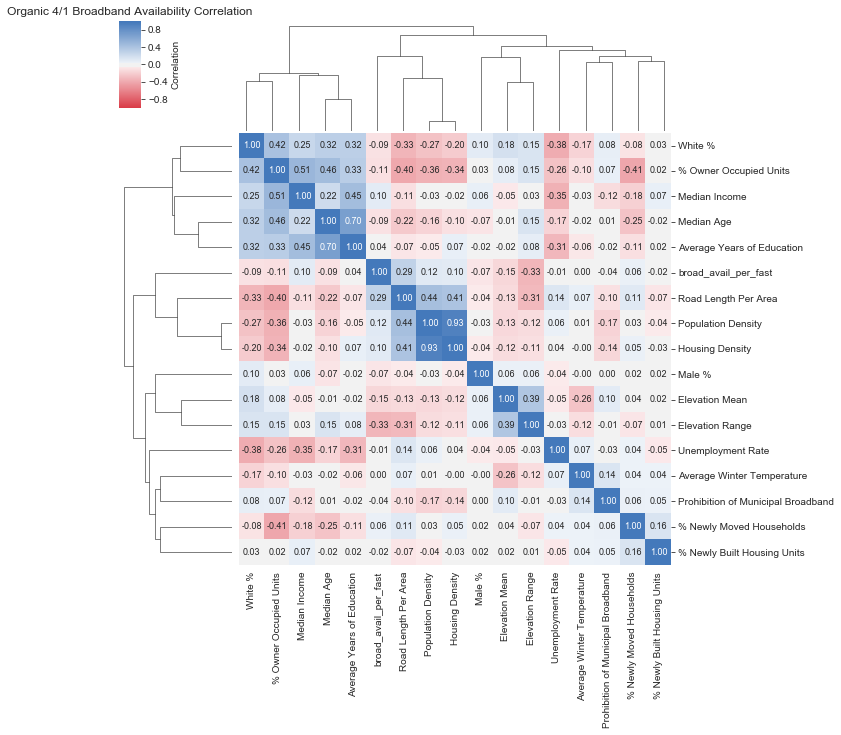

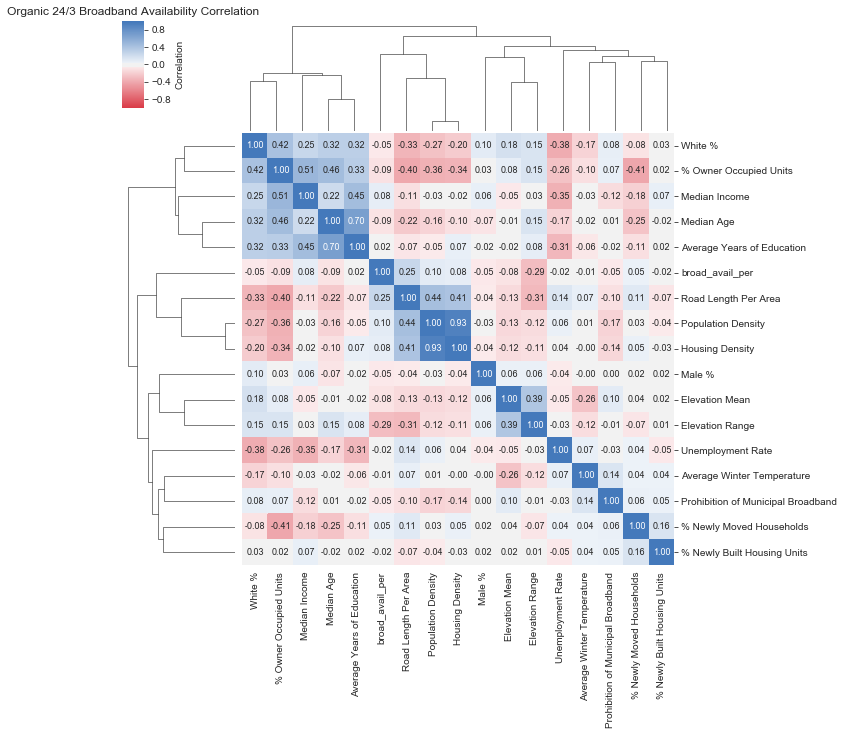

In [10]:
sns.clustermap(data.drop(columns='broad_avail_per').corr(), cmap=sns.diverging_palette(10, 250, as_cmap=True), 
               square=True, vmin=-1.0, vmax=1.0, annot=True, fmt='.2f', annot_kws={'size': 9}, 
               cbar_kws={'label': 'Correlation'})
plt.title('Organic 4/1 Broadband Availability Correlation')
plt.show()

sns.clustermap(data.drop(columns='broad_avail_per_fast').corr(), cmap=sns.diverging_palette(10, 250, as_cmap=True), 
               square=True, vmin=-1.0, vmax=1.0, annot=True, fmt='.2f', annot_kws={'size': 9}, 
               cbar_kws={'label': 'Correlation'})
plt.title('Organic 24/3 Broadband Availability Correlation')
plt.show()

# Building a classification model for broadband availability.

In [11]:
pd.options.mode.chained_assignment = None
data['is_full_coverage'] = (data['broad_avail_per'] == 1)
data['is_full_coverage_fast'] = (data['broad_avail_per_fast'] == 1)

In [12]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

target_cols = ['is_full_coverage', 'is_full_coverage_fast']
X = data.drop(columns=['broad_avail_per', 'broad_avail_per_fast', 'block_group', *target_cols])
    
y = data[target_cols[0]]
w = compute_sample_weight('balanced', y)

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, stratify=y)

### Tuning tree-specific parameters
Tuning max_depth and min_samples_split first as they will have the highest impact on model outcome.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_fix = {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'max_features': 'sqrt',
             'min_samples_leaf': 50}

clf = GradientBoostingClassifier(**param_fix)

param_grid = {'max_depth': np.linspace(20, 40, 3, dtype=int),
              'min_samples_split': np.linspace(40, 60, 3, dtype=int)}

grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train.values, y_train.values, **{'sample_weight': w_train})

print('Grid Searched Train Score:', grid_search.score(X_train, y_train))
print('Grid Searched Test Score:', grid_search.score(X_test, y_test))
print('Best Parameters:', grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 29.0min finished


Grid Searched Train Score: 0.9860846387863184
Grid Searched Test Score: 0.8505817550681355
Best Parameters: {'max_depth': 20, 'min_samples_split': 60}


Confusion matrix, without normalization


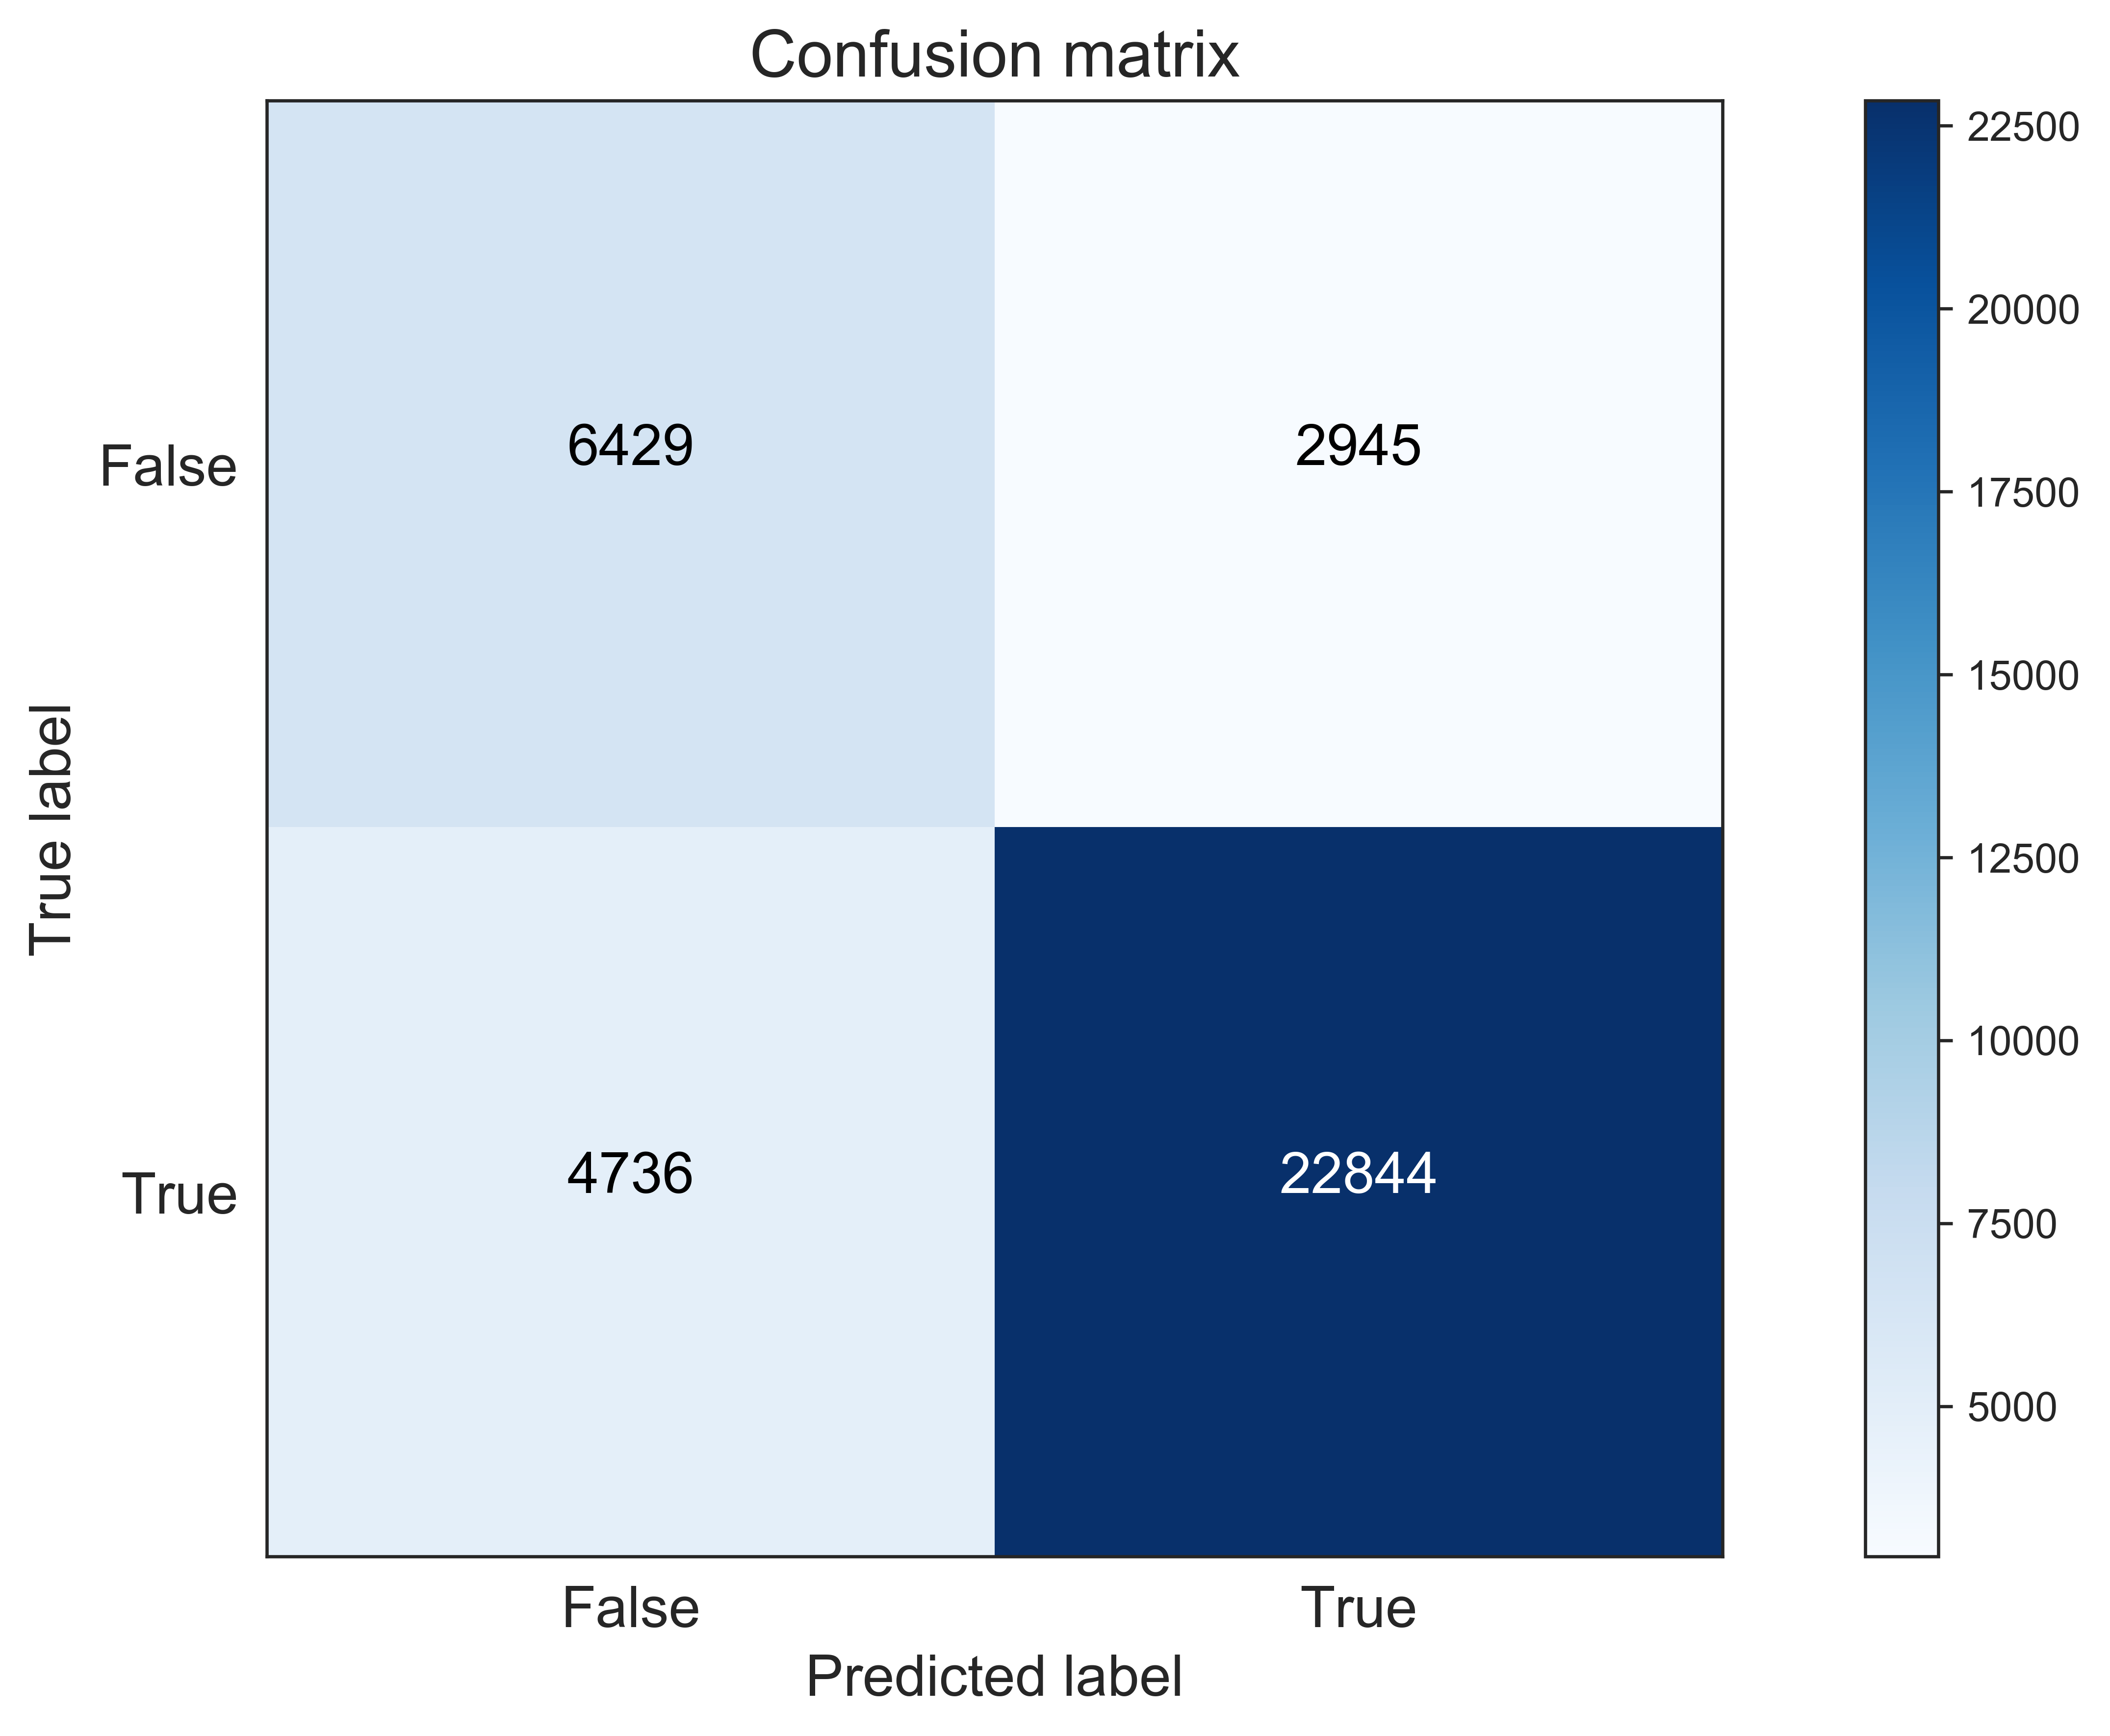

In [14]:
sns.set_style('white')

y_test_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=[False, True])

# Building a similar classification model for high speed broadband availability.

In [15]:
from sklearn.base import clone

y = data[target_cols[1]]
w = compute_sample_weight('balanced', y)

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, stratify=y)
    
grid_search_fast = clone(grid_search)
grid_search_fast.fit(X_train.values, y_train.values, **{'sample_weight': w_train})

print('Grid Searched Train Score:', grid_search_fast.score(X_train, y_train))
print('Grid Searched Test Score:', grid_search_fast.score(X_test, y_test))
print('Best Parameters:', grid_search_fast.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 30.6min finished


Grid Searched Train Score: 0.9841052704113475
Grid Searched Test Score: 0.8534364396212706
Best Parameters: {'max_depth': 20, 'min_samples_split': 40}


Confusion matrix, without normalization


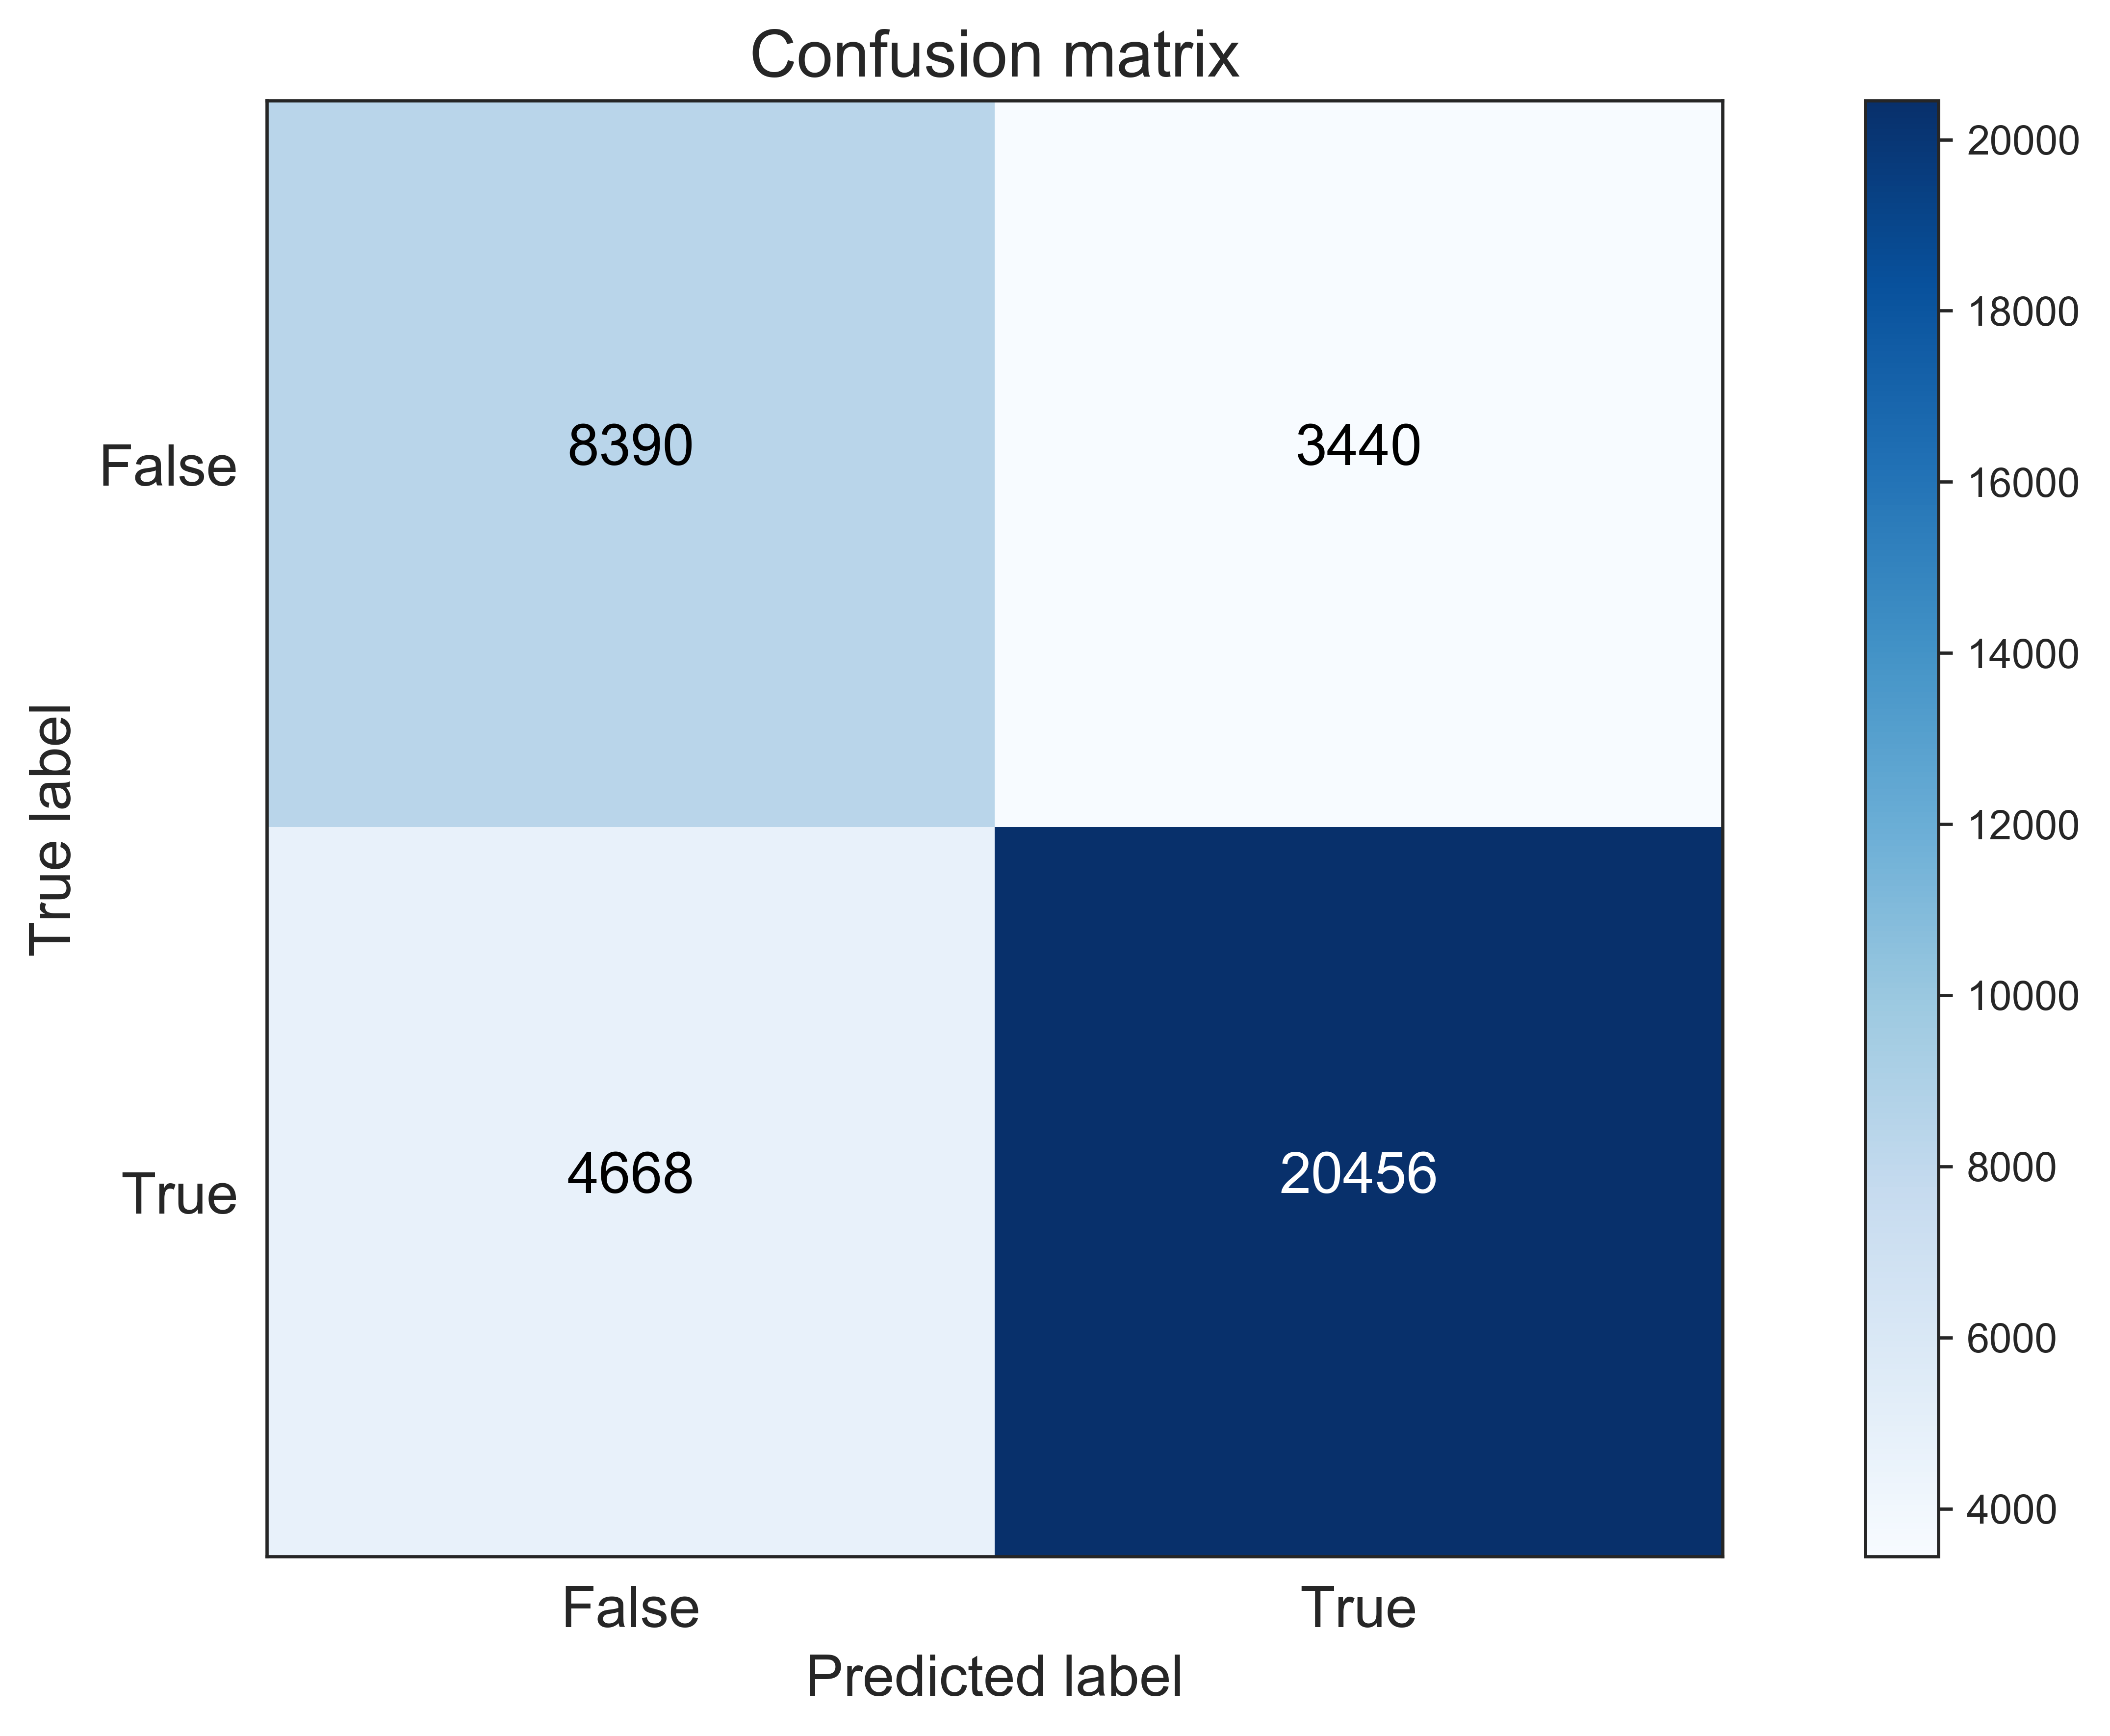

In [16]:
sns.set_style('white')

y_test_pred = grid_search_fast.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=[False, True])

# Finding important features.

In [17]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(grid_search.best_estimator_).fit(X_test, y_test)
perm_fast = PermutationImportance(grid_search_fast.best_estimator_).fit(X_test, y_test)

coefficients = pd.DataFrame(list(zip(X.columns, perm.feature_importances_, perm_fast.feature_importances_)) ,
                            columns=['feature', 'Importance for 4/1 Broadband', 'Importance for 25/3 Broadband'])
coefficients_sort = coefficients.sort_values('Importance for 4/1 Broadband', ascending=False)

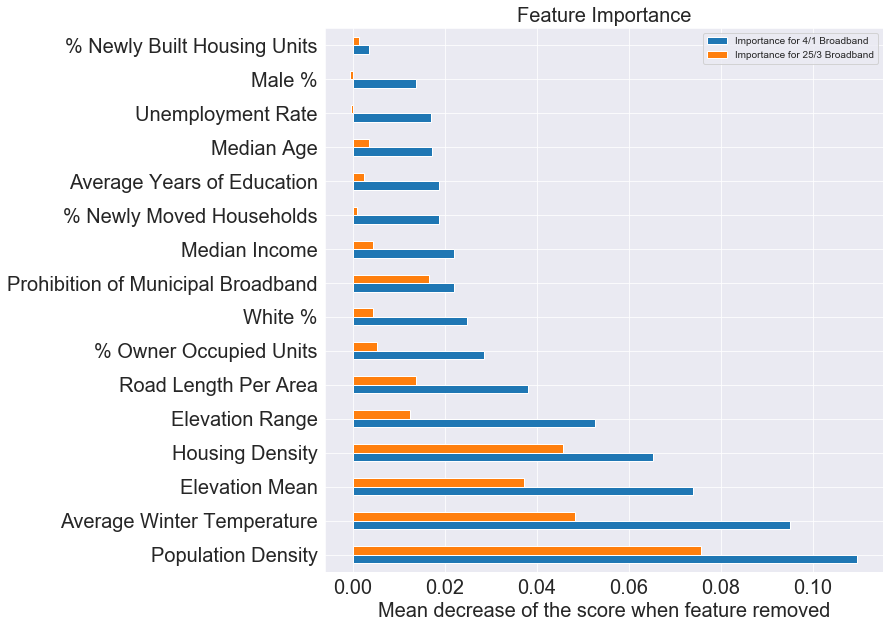

In [18]:
sns.set_style('darkgrid')

coefficients_sort.plot.barh(x='feature', figsize=(10, 10))
plt.xticks(fontsize=20)
plt.xlabel('Mean decrease of the score when feature removed', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('')
plt.title('Feature Importance', fontsize=20)
plt.show()

# Finding partial dependance.

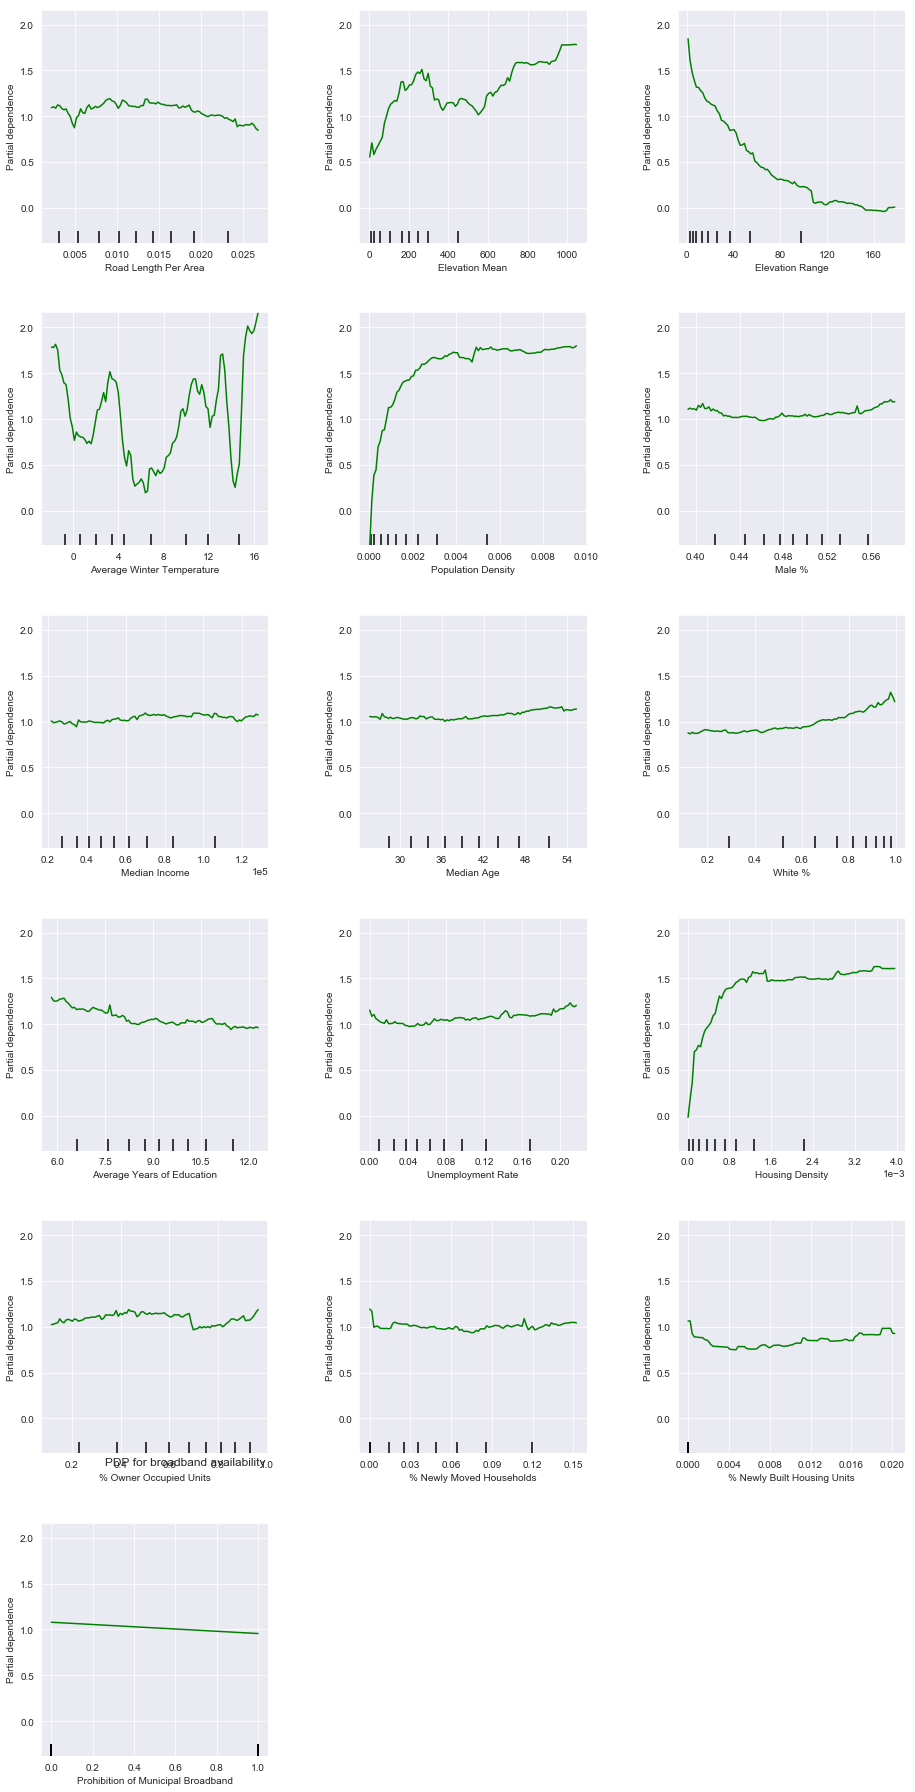

In [19]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

n_f = len(X.columns)

plot_partial_dependence(grid_search.best_estimator_, X_train, range(n_f), feature_names=X.columns, figsize=(5,5),
                        percentiles=(0.05, 0.95))
plt.subplots_adjust(top=5, right=2.5) 
plt.suptitle('PDP for broadband availability')
plt.show()

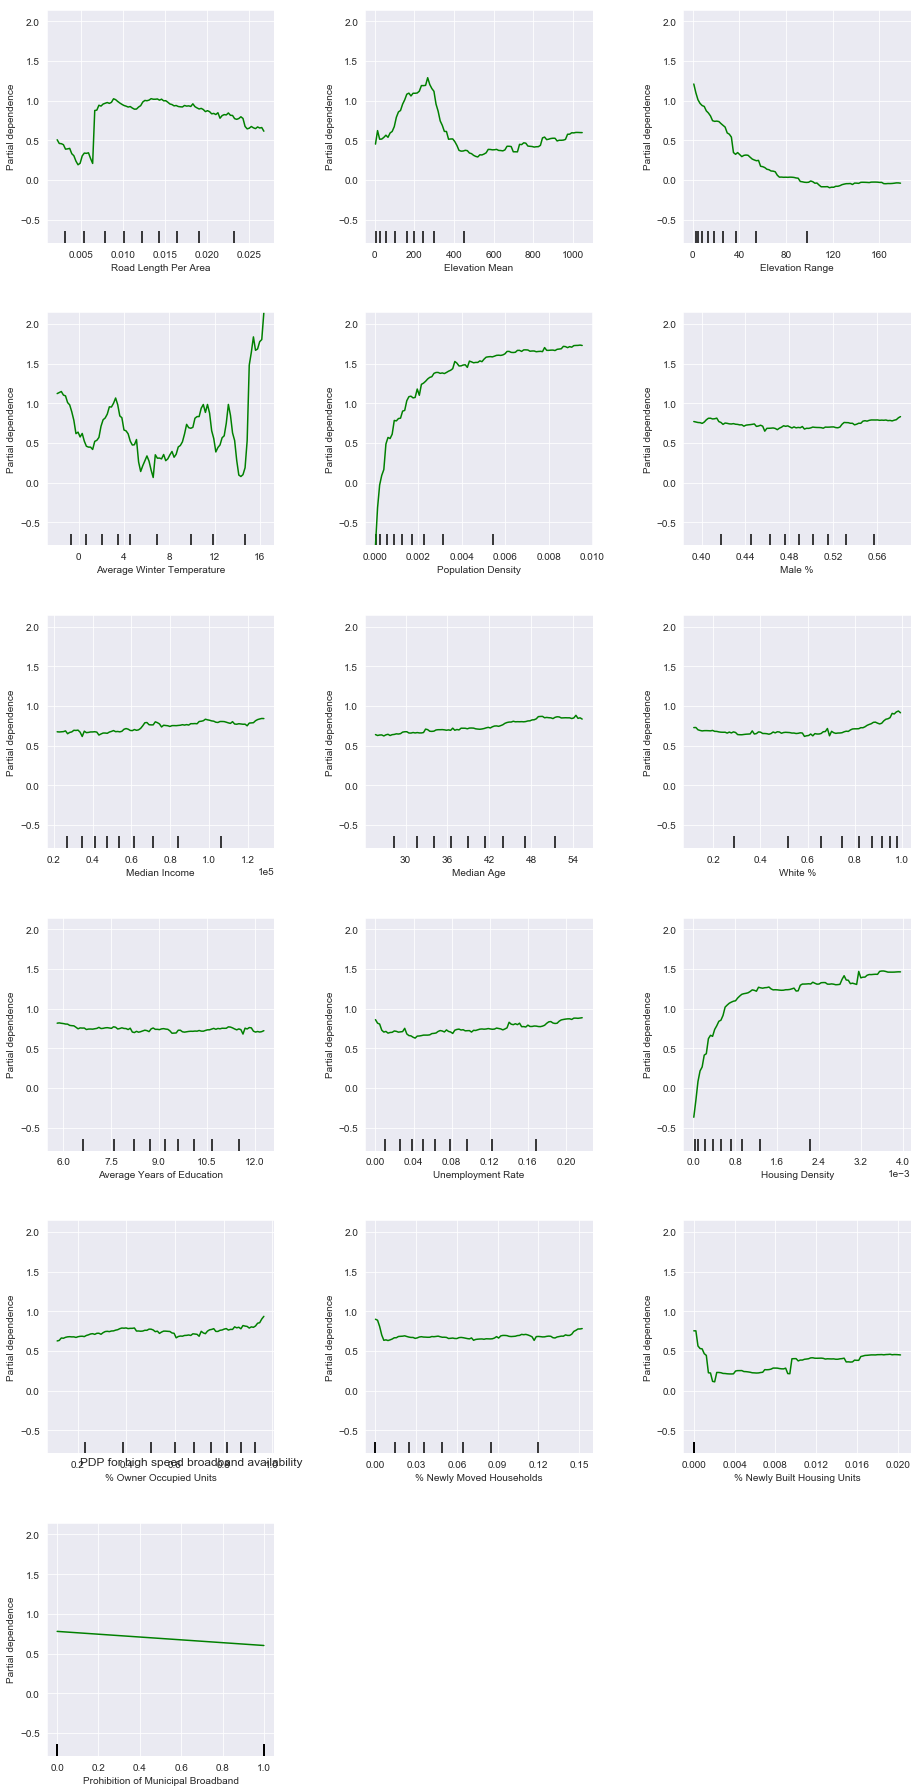

In [20]:
plot_partial_dependence(grid_search_fast.best_estimator_, X_train, range(n_f), feature_names=X.columns, 
                        figsize=(5,5), percentiles=(0.05, 0.95))
plt.subplots_adjust(top=5, right=2.5) 
plt.suptitle('PDP for high speed broadband availability')
plt.show()

# Predicting the areas that is most likely to have full coverage

In [21]:
from sklearn.model_selection import cross_val_predict

y_pred = data['is_full_coverage']
y_pred_fast = data['is_full_coverage_fast']

proba = cross_val_predict(grid_search.best_estimator_, X, y_pred, method='predict_proba', cv=3)
proba_fast = cross_val_predict(grid_search_fast.best_estimator_, X, y_pred_fast, method='predict_proba', cv=3)

data['proba'] = proba[:, 1]
data['proba_fast'] = proba_fast[:, 1]

cols = ['block_group', 'proba', 'proba_fast', 'broad_avail_per', 'broad_avail_per_fast']
coverage = data[cols]

In [22]:
coverage.to_csv('broadband_prediction_bg_result.csv', index=False)